# Women in Data Science Hackaton


This notebook is a tutorial for the WiDS Hackathon. In this notebook, we will walk through the end to end process of getting the data, exploring it, feature engineering, modeling, evaluation and submission.

This notebook is only meant to be a starting point. There are multiple areas that we will not cover. When we deal with issues such as data cleaning or model choice, we would only explore 1 or 2 options.

We will use 2 Machine Learning models: a simple linear regression, and gradient boosting trees using the LightGBM implementation.

Other approaches that can be explored are time series methods such as [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) and deep learning methods for squence modeling and tabular data.
This notebook should be used as a benchmark, upon which you can improve your model.

\
**Reference Links**:

[Registration Form](https://airtable.com/shrSmOC8mMDjc4dFl) for Participating;

[Kaggle Datathon Challenge Page](https://www.kaggle.com/competitions/widsdatathon2023/overview);



# Download Data from Kaggle
1. First, you should log in or sign-up to [Kaggle](https://www.kaggle.com/)
2. Go to "Account"
3. Click on "Create New API Token" under 'API' section
4. Step 3 should trigger the download the "kaggle.json" credential (likely be sitting in your Downloads/)
5. Upload the "kaggle.json" file to this Colab:

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"drgilermo","key":"abb66e96474cef06cb6a82462bc02293"}'}

In [ ]:
#@title Download the WiDS datasets
#@markdown Make sure your credentials are up-to-date and you have accepted the competition's terms and conditions

# setups
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

! cd content
! kaggle competitions download -c widsdatathon2023
! unzip /content/widsdatathon2023.zip


mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                              title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ahsan81/hotel-reservations-classification-dataset                Hotel Reservations Dataset                          480KB  2023-01-04 12:50:31           5891        205  1.0              
themrityunjaypathak/most-subscribed-1000-youtube-channels        Most Subscribed 1000 Youtube Channels                28KB  2023-01-21 14:42:05            545         26  1.0              
senapatirajesh/netflix-tv-shows-and-movies                       Latest Netflix TV shows and movies                    1MB  2023-01-14 17:03:12           2037         59  0.9411765    

# Import Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import FunctionTransformer

# Models
from sklearn.linear_model import LinearRegression # Linear regression
import lightgbm as lgb # Gradient Boosting Trees


import time

## Load Data

In [ ]:
train_df = pd.read_csv('/content/train_data.csv')
display(train_df.head().style.set_caption('Train data'))

test_df = pd.read_csv('/content/test_data.csv')
display(test_df.head().style.set_caption('Test data'))

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,nmme0-tmp2m-34w__nmme0mean,contest-wind-h10-14d__wind-hgt-10,nmme-tmp2m-56w__cancm3,nmme-tmp2m-56w__cancm4,nmme-tmp2m-56w__ccsm3,nmme-tmp2m-56w__ccsm4,nmme-tmp2m-56w__cfsv2,nmme-tmp2m-56w__gfdl,nmme-tmp2m-56w__gfdlflora,nmme-tmp2m-56w__gfdlflorb,nmme-tmp2m-56w__nasa,nmme-tmp2m-56w__nmmemean,contest-rhum-sig995-14d__rhum,nmme-prate-34w__cancm3,nmme-prate-34w__cancm4,nmme-prate-34w__ccsm3,nmme-prate-34w__ccsm4,nmme-prate-34w__cfsv2,nmme-prate-34w__gfdl,nmme-prate-34w__gfdlflora,nmme-prate-34w__gfdlflorb,nmme-prate-34w__nasa,nmme-prate-34w__nmmemean,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,nmme0-prate-56w__cancm40,nmme0-prate-56w__ccsm30,nmme0-prate-56w__ccsm40,nmme0-prate-56w__cfsv20,nmme0-prate-56w__gfdlflora0,nmme0-prate-56w__gfdlflorb0,nmme0-prate-56w__gfdl0,nmme0-prate-56w__nasa0,nmme0-prate-56w__nmme0mean,nmme0-prate-34w__cancm30,nmme0-prate-34w__cancm40,nmme0-prate-34w__ccsm30,nmme0-prate-34w__ccsm40,nmme0-prate-34w__cfsv20,nmme0-prate-34w__gfdlflora0,nmme0-prate-34w__gfdlflorb0,nmme0-prate-34w__gfdl0,nmme0-prate-34w__nasa0,nmme0-prate-34w__nmme0mean,contest-tmp2m-14d__tmp2m,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,nmme-prate-56w__cancm3,nmme-prate-56w__cancm4,nmme-prate-56w__ccsm3,nmme-prate-56w__ccsm4,nmme-prate-56w__cfsv2,nmme-prate-56w__gfdl,nmme-prate-56w__gfdlflora,nmme-prate-56w__gfdlflorb,nmme-prate-56w__nasa,nmme-prate-56w__nmmemean,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,nmme-tmp2m-34w__cancm3,nmme-tmp2m-34w__cancm4,nmme-tmp2m-34w__ccsm3,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-34w__nasa,nmme-tmp2m-34w__nmmemean,contest-prwtr-eatm-14d__prwtr,contest-wind-vwnd-250-14d__wind-vwnd-250,contest-precip-14d__precip,contest-wind-h850-14d__wind-hgt-850,contest-wind-uwnd-925-14d__wind-uwnd-925,contest-wind-h500-14d__wind-hgt-500,cancm30,cancm40,ccsm30,ccsm40,cfsv20,gfdlflora0,gfdlflorb0,gfdl0,nasa0,nmme0mean,climateregions__climateregion,elevation__elevation,wind-vwnd-250-2010-1,wind-vwnd-250-2010-2,wind-vwnd-250-2010-3,wind-vwnd-250-2010-4,wind-vwnd-250-2010-5,wind-vwnd-250-2010-6,wind-vwnd-250-2010-7,wind-vwnd-250-2010-8,wind-vwnd-250-2010-9,wind-vwnd-250-2010-10,wind-vwnd-250-2010-11,wind-vwnd-250-2010-12,wind-vwnd-250-2010-13,wind-vwnd-250-2010-14,wind-vwnd-250-2010-15,wind-vwnd-250-2010-16,wind-vwnd-250-2010-17,wind-vwnd-250-2010-18,wind-vwnd-250-2010-19,wind-vwnd-250-2010-20,wind-uwnd-250-2010-1,wind-uwnd-250-2010-2,wind-uwnd-250-2010-3,wind-uwnd-250-2010-4,wind-uwnd-250-2010-5,wind-uwnd-250-2010-6,wind-uwnd-250-2010-7,wind-uwnd-250-2010-8,wind-uwnd-250-2010-9,wind-uwnd-250-2010-10,wind-uwnd-250-2010-11,wind-uwnd-250-2010-12,wind-uwnd-250-2010-13,wind-uwnd-250-2010-14,wind-uwnd-250-2010-15,wind-uwnd-250-2010-16,wind-uwnd-250-2010-17,wind-uwnd-250-2010-18,wind-uwnd-250-2010-19,wind-uwnd-250-2010-20,mjo1d__phase,mjo1d__amplitude,mei__mei,mei__meirank,mei__nip,wind-hgt-850-2010-1,wind-hgt-850-2010-2,wind-hgt-850-2010-3,wind-hgt-850-2010-4,wind-hgt-850-2010-5,wind-hgt-850-2010-6,wind-hgt-850-2010-7,wind-hgt-850-2010-8,wind-hgt-850-2010-9,wind-hgt-850-2010-10,sst-2010-1,sst-2010-2,sst-2010-3,sst-2010-4,sst-2010-5,sst-2010-6,sst-2010-7,sst-2010-8,sst-2010-9,sst-2010-10,wind-hgt-500-2010-1,wind-hgt-500-2010-2,wind-hgt-500-2010-3,wind-hgt-500-2010-4,wind-hgt-500-2010-5,wind-hgt-500-2010-6,wind-hgt-500-2010-7,wind-hgt-500-2010-8,wind-hgt-500-2010-9,wind-hgt-500-2010-10,icec-2010-1,icec-2010-2,icec-2010-3,icec-2010-4,icec-2010-5,icec-2010-6,icec-2010-7,icec-2010-8,icec-2010-9,icec-2010-10,wind-uwnd-925-2010-1,wind-uwnd-925-2010-2,wind-uwnd-925-2010-3,wind-uwnd-925-2010-4,wind-uwnd-925-2010

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,nmme0-tmp2m-34w__nmme0mean,contest-wind-h10-14d__wind-hgt-10,nmme-tmp2m-56w__cancm3,nmme-tmp2m-56w__cancm4,nmme-tmp2m-56w__ccsm3,nmme-tmp2m-56w__ccsm4,nmme-tmp2m-56w__cfsv2,nmme-tmp2m-56w__gfdl,nmme-tmp2m-56w__gfdlflora,nmme-tmp2m-56w__gfdlflorb,nmme-tmp2m-56w__nasa,nmme-tmp2m-56w__nmmemean,contest-rhum-sig995-14d__rhum,nmme-prate-34w__cancm3,nmme-prate-34w__cancm4,nmme-prate-34w__ccsm3,nmme-prate-34w__ccsm4,nmme-prate-34w__cfsv2,nmme-prate-34w__gfdl,nmme-prate-34w__gfdlflora,nmme-prate-34w__gfdlflorb,nmme-prate-34w__nasa,nmme-prate-34w__nmmemean,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,nmme0-prate-56w__cancm40,nmme0-prate-56w__ccsm30,nmme0-prate-56w__ccsm40,nmme0-prate-56w__cfsv20,nmme0-prate-56w__gfdlflora0,nmme0-prate-56w__gfdlflorb0,nmme0-prate-56w__gfdl0,nmme0-prate-56w__nasa0,nmme0-prate-56w__nmme0mean,nmme0-prate-34w__cancm30,nmme0-prate-34w__cancm40,nmme0-prate-34w__ccsm30,nmme0-prate-34w__ccsm40,nmme0-prate-34w__cfsv20,nmme0-prate-34w__gfdlflora0,nmme0-prate-34w__gfdlflorb0,nmme0-prate-34w__gfdl0,nmme0-prate-34w__nasa0,nmme0-prate-34w__nmme0mean,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,nmme-prate-56w__cancm3,nmme-prate-56w__cancm4,nmme-prate-56w__ccsm3,nmme-prate-56w__ccsm4,nmme-prate-56w__cfsv2,nmme-prate-56w__gfdl,nmme-prate-56w__gfdlflora,nmme-prate-56w__gfdlflorb,nmme-prate-56w__nasa,nmme-prate-56w__nmmemean,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,nmme-tmp2m-34w__cancm3,nmme-tmp2m-34w__cancm4,nmme-tmp2m-34w__ccsm3,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-34w__nasa,nmme-tmp2m-34w__nmmemean,contest-prwtr-eatm-14d__prwtr,contest-wind-vwnd-250-14d__wind-vwnd-250,contest-precip-14d__precip,contest-wind-h850-14d__wind-hgt-850,contest-wind-uwnd-925-14d__wind-uwnd-925,contest-wind-h500-14d__wind-hgt-500,cancm30,cancm40,ccsm30,ccsm40,cfsv20,gfdlflora0,gfdlflorb0,gfdl0,nasa0,nmme0mean,climateregions__climateregion,elevation__elevation,wind-vwnd-250-2010-1,wind-vwnd-250-2010-2,wind-vwnd-250-2010-3,wind-vwnd-250-2010-4,wind-vwnd-250-2010-5,wind-vwnd-250-2010-6,wind-vwnd-250-2010-7,wind-vwnd-250-2010-8,wind-vwnd-250-2010-9,wind-vwnd-250-2010-10,wind-vwnd-250-2010-11,wind-vwnd-250-2010-12,wind-vwnd-250-2010-13,wind-vwnd-250-2010-14,wind-vwnd-250-2010-15,wind-vwnd-250-2010-16,wind-vwnd-250-2010-17,wind-vwnd-250-2010-18,wind-vwnd-250-2010-19,wind-vwnd-250-2010-20,wind-uwnd-250-2010-1,wind-uwnd-250-2010-2,wind-uwnd-250-2010-3,wind-uwnd-250-2010-4,wind-uwnd-250-2010-5,wind-uwnd-250-2010-6,wind-uwnd-250-2010-7,wind-uwnd-250-2010-8,wind-uwnd-250-2010-9,wind-uwnd-250-2010-10,wind-uwnd-250-2010-11,wind-uwnd-250-2010-12,wind-uwnd-250-2010-13,wind-uwnd-250-2010-14,wind-uwnd-250-2010-15,wind-uwnd-250-2010-16,wind-uwnd-250-2010-17,wind-uwnd-250-2010-18,wind-uwnd-250-2010-19,wind-uwnd-250-2010-20,mjo1d__phase,mjo1d__amplitude,mei__mei,mei__meirank,mei__nip,wind-hgt-850-2010-1,wind-hgt-850-2010-2,wind-hgt-850-2010-3,wind-hgt-850-2010-4,wind-hgt-850-2010-5,wind-hgt-850-2010-6,wind-hgt-850-2010-7,wind-hgt-850-2010-8,wind-hgt-850-2010-9,wind-hgt-850-2010-10,sst-2010-1,sst-2010-2,sst-2010-3,sst-2010-4,sst-2010-5,sst-2010-6,sst-2010-7,sst-2010-8,sst-2010-9,sst-2010-10,wind-hgt-500-2010-1,wind-hgt-500-2010-2,wind-hgt-500-2010-3,wind-hgt-500-2010-4,wind-hgt-500-2010-5,wind-hgt-500-2010-6,wind-hgt-500-2010-7,wind-hgt-500-2010-8,wind-hgt-500-2010-9,wind-hgt-500-2010-10,icec-2010-1,icec-2010-2,icec-2010-3,icec-2010-4,icec-2010-5,icec-2010-6,icec-2010-7,icec-2010-8,icec-2010-9,icec-2010-10,wind-uwnd-925-2010-1,wind-uwnd-925-2010-2,wind-uwnd-925-2010-3,wind-uwnd-925-2010-4,wind-uwnd-925-2010-5,wind-uwnd-925-2010-6,w

# Examine the Data

#### Dimensions
Let's look at the data. First, let's see the shape. How many columns and rows we have:

In [ ]:
train_df.shape

(375734, 246)

In [ ]:
test_df.shape

(31354, 245)

#### Column Types & Missing Values

In [ ]:
train_df.dtypes

index                                   int64
lat                                   float64
lon                                   float64
startdate                              object
contest-pevpr-sfc-gauss-14d__pevpr    float64
                                       ...   
wind-vwnd-925-2010-16                 float64
wind-vwnd-925-2010-17                 float64
wind-vwnd-925-2010-18                 float64
wind-vwnd-925-2010-19                 float64
wind-vwnd-925-2010-20                 float64
Length: 246, dtype: object

#### Target
Target column should be `contest-tmp2m-14d__tmp2m`, which appears in the training data, but it doesn't appear in the test data:

In [ ]:
target = [c for c in train_df.columns if c not in test_df.columns][0]
print(target)

contest-tmp2m-14d__tmp2m


In [ ]:
train_df[target].describe()

count    375734.000000
mean         11.858568
std           9.867901
min         -20.358963
25%           4.818231
50%          12.285770
75%          19.441170
max          37.238782
Name: contest-tmp2m-14d__tmp2m, dtype: float64

Let's transform the time feature to datetime for further analysis:

In [ ]:
train_df.startdate = pd.to_datetime(train_df.startdate)
test_df.startdate = pd.to_datetime(test_df.startdate)

Let's plot the target variable:

Text(0.5, 0, 'Date')

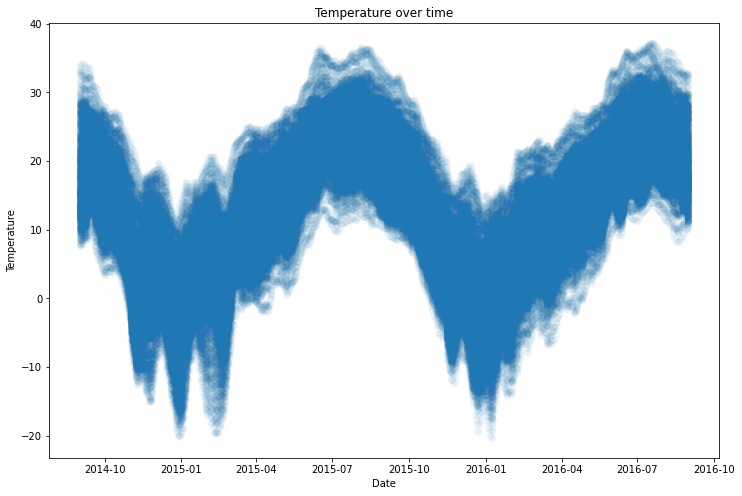

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(train_df.startdate,
         train_df[target],
         'o',
         alpha=0.03)
plt.title('Temperature over time')
plt.ylabel('Temperature')
plt.xlabel('Date')

Let's also look at the distribution of temperatures:

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


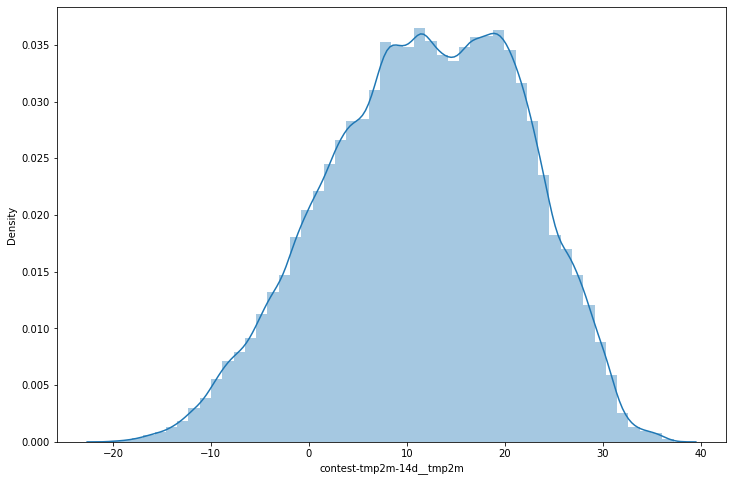

In [ ]:
plt.figure(figsize=(12, 8))
sns.distplot(train_df[target])

We have multiple regions, let's create a new feature called "loc_group", based on lat-lon cooredinates:

In [ ]:
train_df['loc_group'] = train_df.groupby(['lat','lon']).ngroup()
train_df['loc_group'].nunique()

514

We have 514 different regions.

Let's plot the temperature for the different location groups:

<Figure size 864x576 with 0 Axes>

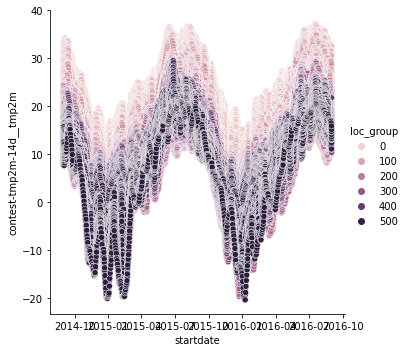

In [ ]:
plt.figure(figsize=(12, 8))
sns.relplot(data=train_df,
            x='startdate',
            y='contest-tmp2m-14d__tmp2m',
            hue='loc_group')


# Exploratory Data Analysis (EDA)
Let's start with a basic EDA to get an overview of the data.

Let's start with a very simple and naive correlation plot and see what features correlate (linearly) with our target variable. We should keep in mind that correlations are a very bsasic tool. They can't capture non-linear relations, and are not ideal for categorical and some raw features (like cooredinates)

In [ ]:
target = 'contest-tmp2m-14d__tmp2m'
train_df.corr()[target].sort_values()

wind-hgt-10-2010-1         -0.815701
wind-vwnd-925-2010-1       -0.807371
wind-hgt-500-2010-1        -0.806078
wind-hgt-100-2010-1        -0.802240
wind-hgt-850-2010-1        -0.779923
                              ...   
nmme-tmp2m-34w__nmmemean    0.950187
nmme-tmp2m-56w__nmmemean    0.950865
nmme-tmp2m-34w__cfsv2       0.954483
nmme-tmp2m-56w__cfsv2       0.954668
contest-tmp2m-14d__tmp2m    1.000000
Name: contest-tmp2m-14d__tmp2m, Length: 245, dtype: float64

We can see that some features are very highly correlated (both negative and positive are very informative). We can use the most informative features for a simple benchmark model

Text(0.5, 0, 'Most correlated feature (nmme-tmp2m-56w__cfsv2)')

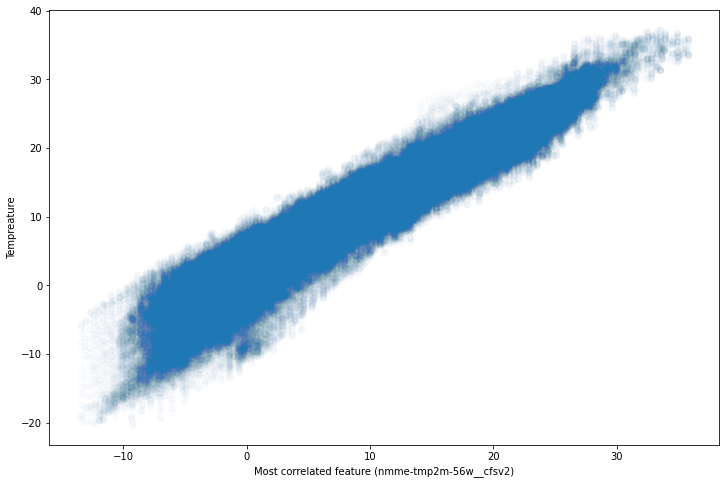

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(train_df['nmme-tmp2m-56w__cfsv2'],
            train_df[target],
            alpha=0.01)
plt.ylabel('Tempreature')
plt.xlabel('Most correlated feature (nmme-tmp2m-56w__cfsv2)')

Let's look at our categorical features:

In [ ]:
train_df.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('<M8[ns]'), dtype('O')],
      dtype=object)

In [ ]:
train_df.dtypes.sort_values()

index                              int64
mei__nip                           int64
mei__meirank                       int64
mjo1d__phase                       int64
loc_group                          int64
                                  ...   
ccsm30                           float64
ccsm40                           float64
gfdlflora0                       float64
wind-uwnd-250-2010-3             float64
climateregions__climateregion     object
Length: 247, dtype: object

We have only one categorical feature, and that is "climateregions__climateregion"

In [ ]:
train_df.groupby('climateregions__climateregion').mean()[target]

climateregions__climateregion
BSh    20.883240
BSk    11.103087
BWh    22.196044
BWk    15.865922
Cfa    17.906166
Cfb    10.832186
Csa    15.686419
Csb    11.523091
Dfa    10.494672
Dfb     6.893599
Dfc     4.406667
Dsb     9.038471
Dsc     7.344342
Dwa     9.741287
Dwb     8.012755
Name: contest-tmp2m-14d__tmp2m, dtype: float64

We can see that the 'climateregions__climateregion' feature is also high informative as the average temperature varies significantly between regions

# Preprocessing

Preprocessing should take into account:
1. Missing and invalid values
2. Categorical values

Let's check for null values:

In [ ]:
train_df.isnull().values.any()


True

In [ ]:
for col in train_df.columns:
    if train_df[col].isnull().values.any():
        print(col, train_df[col].isnull().values.sum())

nmme0-tmp2m-34w__ccsm30 15934
nmme-tmp2m-56w__ccsm3 10280
nmme-prate-34w__ccsm3 8738
nmme0-prate-56w__ccsm30 15934
nmme0-prate-34w__ccsm30 15934
nmme-prate-56w__ccsm3 10280
nmme-tmp2m-34w__ccsm3 8738
ccsm30 15934


We have missing values in a few columns. not in our target columns though. We can deal with missing values with a few imperfect ways:
1. discard them (but then we lose some data)
2. Impute with a very large/small number to indicate that the data is missing (but this can be misleading for some of the models such as linear models)
3. Impute them with the mean - a simple solution that adds some artifical bias to our data
4. Sample from a distribution or predict the missing values based on the other features - probably the most robust method but also the most complex one.

We will use the very imperfect mean imputation

In [ ]:
for col in train_df.columns:
    if train_df[col].isnull().values.any():
        train_df[col].fillna(train_df[col].mean(), inplace=True)

Next we will deal with the categorical feature. We only have one categorical feature. We can encode it in several ways:
1. One-hot encoding - turn the feature into 15 binary columns (because there are 15 distinct values) where the "hot" value is 1 and all the others are 0. That's a very good method when there is a small number of unique values, an gets worse the more unique values we have. What is "large" heavily depends on the data distribution and amount of information stored in the categorical feature. 15 is somewhat borderline.
2. Label-encoding - replace the categorical value with an integer index. This does not increase the dimensionality of the data (we don't have 15 new columns now). However, the integer index is somewhat arbitrary and it implies relations between the categories that are not necessarily true.
3. Target-encoding - replace the categorical value with the average target value for this category. This method is very good but has the risk of overfitting.

We will use label encoding:

In [ ]:
le = preprocessing.LabelEncoder()
train_df['climateregions__climateregion'] = le.fit_transform(train_df['climateregions__climateregion'])

# Feature Engineering
In tabular problems, feature engineering is often the most important part. In feature engineering we create new features that capture the relationship between the target variable and our features best, based on our domain knowledge

### Time Features

In [ ]:
def create_time_features(df):
    df = df.copy()
    df['year'] = df.startdate.dt.year
    df['month'] = df.startdate.dt.month
    df['dayofyear'] = train_df.startdate.dt.day_of_year
    return df

train_df = create_time_features(train_df)
train_df.head()

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20,loc_group,year,month,dayofyear
0,0,0.0,0.833333,2014-09-01,237.00,29.02,31.64,29.57,30.73,29.71,...,-2.03,48.13,28.09,-13.50,11.90,4.58,0,2014,9,244
1,1,0.0,0.833333,2014-09-02,228.90,29.02,31.64,29.57,30.73,29.71,...,4.44,48.60,27.41,-23.77,15.44,3.42,0,2014,9,245
2,2,0.0,0.833333,2014-09-03,220.69,29.02,31.64,29.57,30.73,29.71,...,5.01,48.53,19.21,-33.16,15.11,4.82,0,2014,9,246
3,3,0.0,0.833333,2014-09-04,225.28,29.02,31.64,29.57,30.73,29.71,...,-1.41,50.59,8.29,-37.22,18.24,9.74,0,2014,9,247
4,4,0.0,0.833333,2014-09-05,237.24,29.02,31.64,29.57,30.73,29.71,...,-5.21,54.73,-2.58,-42.30,21.91,10.95,0,2014,9,248


In [ ]:
# Copied from https://colab.research.google.com/drive/10r73mOp1R7cORfeuP97V65a-rgwGyfWr?usp=sharing#scrollTo=c9ZkVb2aU-S7

def add_season(df):
    month_to_season = {
      1: 0,
      2: 0,
      3: 1,
      4: 1,
      5: 1,
      6: 2,
      7: 2,
      8: 2,
      9: 3,
      10: 3,
      11: 3,
      12: 0
  }
    df['season'] = df['month'].apply(lambda x: month_to_season[x])

add_season(train_df)


(Optional) Since time is cyclical, let's add features that express the seasonality and cyclicalness of our data (that's a common transformation for time features):

In [ ]:
# Copied from https://colab.research.google.com/drive/10r73mOp1R7cORfeuP97V65a-rgwGyfWr?usp=sharing#scrollTo=c9ZkVb2aU-S7

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

def encode_cyclical(df):
    # encode the day with a period of 365
    df['day_of_year_sin'] = sin_transformer(365).fit_transform(df['dayofyear'])
    df['day_of_year_cos'] = cos_transformer(365).fit_transform(df['dayofyear'])

    # encode the month with a period of 12
    df['month_sin'] = sin_transformer(12).fit_transform(df['month'])
    df['month_cos'] = cos_transformer(12).fit_transform(df['month'])

    # encode the season with a period of 4
    df['season_sin'] = sin_transformer(4).fit_transform(df['season'])
    df['season_cos'] = cos_transformer(4).fit_transform(df['season'])

encode_cyclical(train_df)

# Modeling
We will use 2 models:
1. Linear Regression
2. Lightgbm


In [ ]:
exclude_cols = ['index', 'startdate']
features = [c for c in train_df.columns if ((c != target) & (c not in exclude_cols))]


# train_df.sort_values(by='startdate', inplace=True) # Verify the data is sorted by time
# train_df.reset_index(inplace=True)
split_point = 0.98 # 98 % training, 2% validation, because we have a lot of data, 2% validation can be enough
train = train_df[:int(split_point*len(train_df))]
val  = train_df[int(split_point*len(train_df)):]

# Altenative - split by time:
# train = train_df[train_df['startdate'] <= '2016-08-17']
# val  = train_df[train_df['startdate'] > '2016-08-17']

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

## Linear Model

In [ ]:
model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

##  Evaluation

When we evaluate our model we need to choose the right metric. The right metric would fit the data distribution as well as the final business KPI we actually care about.

This is a regression model, and therefore we should choose an evaluation metric for a regression problem.
There are a few possiblities:
1. [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error)
2. [R2](https://en.wikipedia.org/wiki/Coefficient_of_determination)
3. [Mean Absolotue Error](https://en.wikipedia.org/wiki/Mean_absolute_error)

And others. We will use the r2_score since running from 0 to 1 (in most cases) is the most intuitive one, as well as RMSE since this is the one used in the Kaggle competition (https://en.wikipedia.org/wiki/Root-mean-square_deviation).

In [ ]:
print(f'Training MSE: {mean_squared_error(y_train, model.predict(X_train))}')
print(f'Validation MSE: {mean_squared_error(y_val, model.predict(X_val))}')

Training MSE: 1.6822183315611532
Validation MSE: 2.5900810141538178


Text(0.5, 1.0, 'Validation r2 for Linear model is 0.9797151727281989')

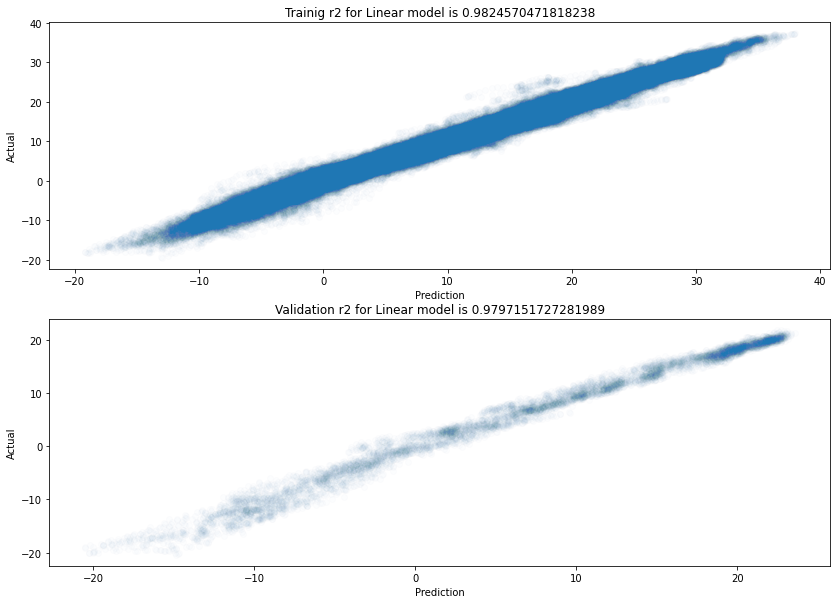

In [ ]:
plt.figure(figsize=(14, 10))

plt.subplot(211)
plt.scatter(model.predict(X_train), y_train, alpha=0.01)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title(f'Trainig r2 for Linear model is {r2_score(y_train, model.predict(X_train))}')

plt.subplot(212)
plt.scatter(model.predict(X_val), y_val, alpha=0.01)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title(f'Validation r2 for Linear model is {r2_score(y_val, model.predict(X_val))}')

##  LightGBM

In [ ]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 5
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=lgb_eval)

Starting training...
[1]	valid_0's l1: 9.88669	valid_0's l2: 156.512
[2]	valid_0's l1: 9.43162	valid_0's l2: 143.153
[3]	valid_0's l1: 9.01627	valid_0's l2: 131.313
[4]	valid_0's l1: 8.60531	valid_0's l2: 120.185
[5]	valid_0's l1: 8.21783	valid_0's l2: 110.277
[6]	valid_0's l1: 7.8652	valid_0's l2: 101.788
[7]	valid_0's l1: 7.51135	valid_0's l2: 93.4403
[8]	valid_0's l1: 7.18524	valid_0's l2: 85.7566
[9]	valid_0's l1: 6.87571	valid_0's l2: 79.0017
[10]	valid_0's l1: 6.57335	valid_0's l2: 72.6945
[11]	valid_0's l1: 6.2933	valid_0's l2: 67.3499
[12]	valid_0's l1: 6.01472	valid_0's l2: 61.8841
[13]	valid_0's l1: 5.74346	valid_0's l2: 56.8498
[14]	valid_0's l1: 5.50386	valid_0's l2: 52.4381
[15]	valid_0's l1: 5.27135	valid_0's l2: 48.5334
[16]	valid_0's l1: 5.05955	valid_0's l2: 45.1374
[17]	valid_0's l1: 4.84492	valid_0's l2: 41.579
[18]	valid_0's l1: 4.64634	valid_0's l2: 38.728
[19]	valid_0's l1: 4.45241	valid_0's l2: 35.8896
[20]	valid_0's l1: 4.28517	valid_0's l2: 33.4893
[21]	valid_0

We can see that while our model fits the training data well (with r2=0.98) it doesn't generalize very well to the validation set and we get r2=0.979. This means we suffer from some overfitting.

In [ ]:
print(f'Training MSE: {mean_squared_error(y_train, gbm.predict(X_train))}')
print(f'Validation MSE: {mean_squared_error(y_val, gbm.predict(X_val))}')

Training MSE: 0.7265050196911933
Validation MSE: 1.243752875373827


Text(0.5, 1.0, 'Validation r2 for LightGBM model is 0.9902592574873545')

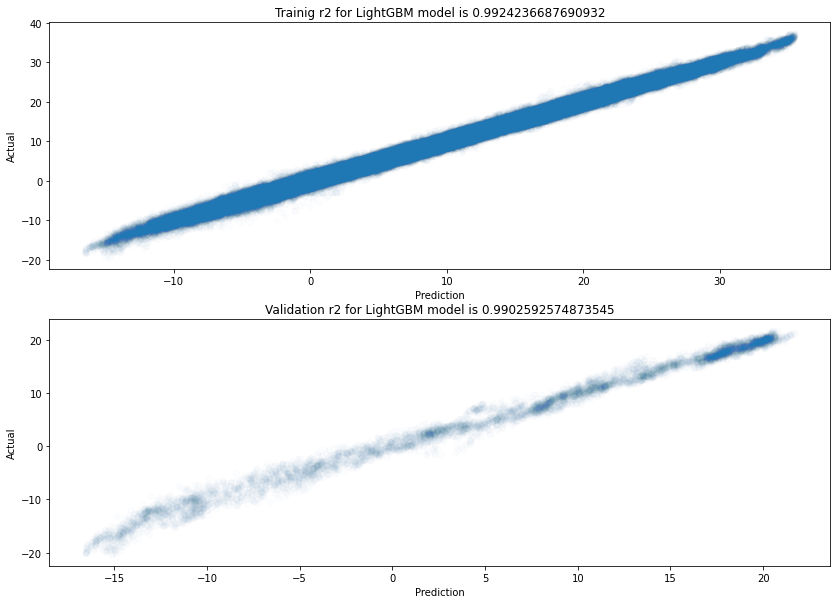

In [ ]:
plt.figure(figsize=(14, 10))

plt.subplot(211)
plt.scatter(gbm.predict(X_train), y_train, alpha=0.01)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title(f'Trainig r2 for LightGBM model is {r2_score(y_train, gbm.predict(X_train))}')

plt.subplot(212)
plt.scatter(gbm.predict(X_val), y_val, alpha=0.01)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title(f'Validation r2 for LightGBM model is {r2_score(y_val, gbm.predict(X_val))}')

# Feature Importance

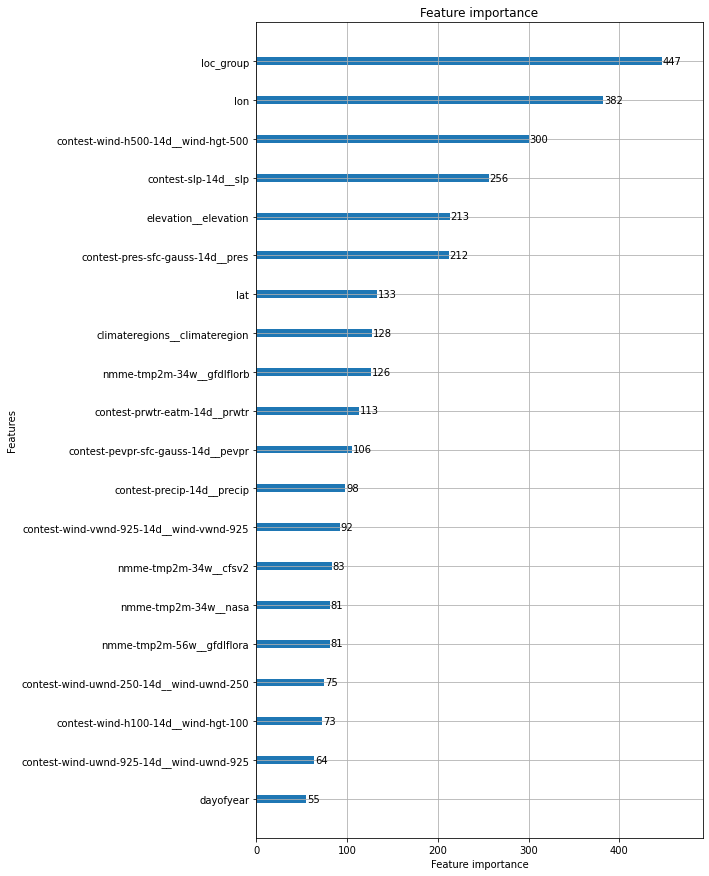

In [ ]:
lgb.plot_importance(gbm, max_num_features=20, figsize=(8,15))

# Hyperparameter Tuning
Hyperparameters are parameters that are not learned from the data. Each model has different hyperparameters. For a linear regression this can be the strength of the regularization parameter. For tree based models such as gradient boosting trees this can constraints on the tree structure such as maximal depth, minimal number of samples per leaf, number of trees, etc.

Many times the hyperparameters are used to optimize the trade-off between fitting the training data and generalization (in other words, the bias-variance or the underiftting-overfitting trade-off/problem).

Hyperoarameters tuning can be done automatically with grid-search, Bayesian optimization or any other kind of way to sample and optimize the space of hyperparameters. However, when we do that we should be careful not to overfit to our validation set. We should also take into account that searching over this multi-dimensional space of possible values may take a lot of time

We will try to tweek some of the lightGBM model hyperparameters.

Our validation score is still lower than the training score. This means that either our model is too simple, and more signal can be captured, our that our model is too complex and therefore doesn't generalize well anymore and is overfitting.

Let's try making our model a bit more complicated and see how the results change:

In [ ]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 5
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=300,
                valid_sets=lgb_eval)

Starting training...
[1]	valid_0's l1: 9.88669	valid_0's l2: 156.512
[2]	valid_0's l1: 9.43162	valid_0's l2: 143.153
[3]	valid_0's l1: 9.01627	valid_0's l2: 131.313
[4]	valid_0's l1: 8.60531	valid_0's l2: 120.185
[5]	valid_0's l1: 8.21783	valid_0's l2: 110.277
[6]	valid_0's l1: 7.8652	valid_0's l2: 101.788
[7]	valid_0's l1: 7.51135	valid_0's l2: 93.4403
[8]	valid_0's l1: 7.18524	valid_0's l2: 85.7566
[9]	valid_0's l1: 6.87571	valid_0's l2: 79.0017
[10]	valid_0's l1: 6.57335	valid_0's l2: 72.6945
[11]	valid_0's l1: 6.2933	valid_0's l2: 67.3499
[12]	valid_0's l1: 6.01472	valid_0's l2: 61.8841
[13]	valid_0's l1: 5.74346	valid_0's l2: 56.8498
[14]	valid_0's l1: 5.50386	valid_0's l2: 52.4381
[15]	valid_0's l1: 5.27135	valid_0's l2: 48.5334
[16]	valid_0's l1: 5.05955	valid_0's l2: 45.1374
[17]	valid_0's l1: 4.84492	valid_0's l2: 41.579
[18]	valid_0's l1: 4.64634	valid_0's l2: 38.728
[19]	valid_0's l1: 4.45241	valid_0's l2: 35.8896
[20]	valid_0's l1: 4.28517	valid_0's l2: 33.4893
[21]	valid_0

In [ ]:
print(f'MSE for training data {mean_squared_error(y_train, gbm.predict(X_train))}')
print(f'MSE for validation data {mean_squared_error(y_val, gbm.predict(X_val))}')

MSE for training data 0.5400800506557973
MSE for validation data 1.016250965663343


Text(0.5, 1.0, 'Validation r2 is 0.9920409920806987')

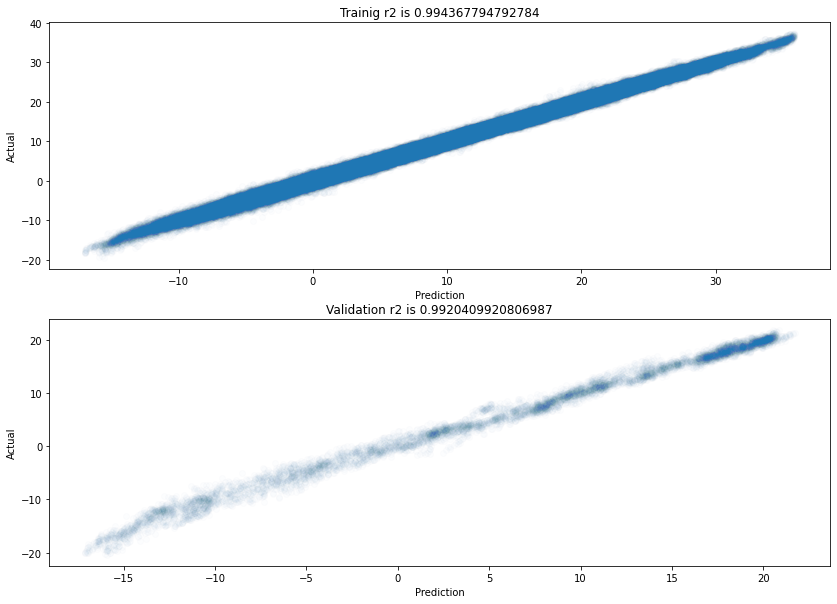

In [ ]:
plt.figure(figsize=(14, 10))

plt.subplot(211)
plt.scatter(gbm.predict(X_train), y_train, alpha=0.01)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title(f'Trainig r2 is {r2_score(y_train, gbm.predict(X_train))}')

plt.subplot(212)
plt.scatter(gbm.predict(X_val), y_val, alpha=0.01)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title(f'Validation r2 is {r2_score(y_val, gbm.predict(X_val))}')

We can see that the validation score improved from 0.99 to 0.992 and more importantly the RMSE when down from 1.24 to 1,01. It may still be that we are overfitting to our validation set. Only after submission we can see how we did on the test dataset.

# Submission

Before submission we need to transform the test dataset using the same transofmrations we used for the training dataset, *but use only transformations and data from the training dataset, to avoid overfitting*

Deal with missing values. Notice that we use the training dataset values to avoid overfitting (since the test data is actually available one might argue that it is OK to use them. And maybe for the sake of competition it's worth trying using the test dataset values for missing values imputation. But in general this os not a good practice):

In [ ]:
for col in test_df.columns:
    if test_df[col].isnull().values.any():
        test_df[col].fillna(train_df[col].mean(), inplace=True)

Categorical data. Here we also have to use the label encoder trained on the training data:

In [ ]:
test_df['climateregions__climateregion'] = le.transform(test_df['climateregions__climateregion'])

Text Features:

In [ ]:
test_df = create_time_features(test_df)

add_season(test_df)
encode_cyclical(test_df)

Encode log group based on loc groups of training data

In [ ]:
temp = train_df.groupby(['lat','lon']).mean()['loc_group'].reset_index()
regions_dict = dict()
for row in temp.iterrows():
  key = str(row[1].lat) + '_' + str(row[1].lon)
  regions_dict[key] = row[1].loc_group

test_df['regions_key'] = test_df.apply(lambda x: str(x.lat) + '_' + str(x.lon),
                                       axis=1)
test_df['loc_group'] = test_df.regions_key.apply(lambda x: regions_dict.get(x, -1))

In [ ]:
submission = pd.read_csv('sample_solution.csv')
display(submission)
submission[target] = gbm.predict(test_df[features])

submission.to_csv('submission.csv',
                  index = False) # Set index to false to avoid issues in evaluation

,contest-tmp2m-14d__tmp2m,index
0,27.073876,375734
1,25.109308,375735
2,22.557390,375736
3,25.572875,375737
4,20.781073,375738
...,...,...
31349,28.303967,407083
31350,26.635933,407084
31351,27.057762,407085
31352,26.871066,407086


Upload this file to the competition page. This submission should give a RMSE of 1.41. which as of January 29th would put you in the 146th place :)

# Next Steps:
Ways you can consider in order to improve your prediction:
1. Time Series models such as ARIMA (notice that you need a multivariate time series model for this problem)
2. Different models: You can try neaural networks. Look for either networks for tabular data (such as TabNet and TabTransformer) or neural networks for squence modeling (like RNNs, LSTM and transformer-based models)
3. Change the categorical features representation to one-hot encoding, target encoding or embedding (you can also use other models that are designed to work with categorical features such as CatBoost)
4. Change the missing values strategy. For example, denote the missing values with a special value, or try to predict the missing value based on other features
5. Try Ensambling different models and submit a weighted average prediction
6. Try splitting the train-validation data based on a different logic (such as seasons)
7. Try different hyperparameters
8. Think of new features that you can engineer from the existing features that would better represent the data using your knowledge of the problem